In [ ]:
"""pip install kaggle"""

'pip install kaggle'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/raf-db-dataset


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ResNetModel, ViTModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Load ResNet-18 (pretrained)
import timm
cnn = timm.create_model('resnet18.a1_in1k', pretrained=True)

# Unfreeze last block of ResNet
for name, param in cnn.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Load DINO-ViT (pretrained)
vit = ViTModel.from_pretrained("facebook/dino-vitb16", use_safetensors=True)

# Unfreeze all layers
for param in vit.parameters():
    param.requires_grad = True

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class CNNtoViT(nn.Module):
    def __init__(self, cnn, vit):
        super().__init__()
        self.cnn = cnn
        self.vit = vit
        self.project = nn.Linear(512, 768)

    def forward(self, x):
       # [B, 512, 7, 7]
        cnn_out = self.cnn.forward_features(x)  # timm-specific feature extractor
        b, c, h, w = cnn_out.shape
         # [B, 49, 512]
        cnn_flat = cnn_out.view(b, c, h * w).permute(0, 2, 1)
        # [B, 49, 768]
        projected = self.project(cnn_flat)

        cls_token = self.vit.embeddings.cls_token.expand(b, -1, -1)
         # [B, 50, 768]
        x = torch.cat((cls_token, projected), dim=1)
        x = x + self.vit.embeddings.position_embeddings[:, :x.size(1), :]
        x = self.vit.embeddings.dropout(x)
        x = self.vit.encoder(x)
         # CLS token
        return x.last_hidden_state[:, 0, :]

In [ ]:
class FullModel(nn.Module):
    def __init__(self, cnn, vit, num_classes=7):
        super().__init__()
        self.backbone = CNNtoViT(cnn, vit)
        self.classifier = nn.Sequential(
                    nn.Linear(768, 256),
                    nn.ReLU(),
                    nn.Dropout(0.5), #increased dropout
                    nn.Linear(256, num_classes)
                )


    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

model = FullModel(cnn, vit)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        logp = F.log_softmax(inputs, dim=1)
        p = torch.exp(logp)
        logp = logp.gather(1, targets.unsqueeze(1)).squeeze(1)
        p = p.gather(1, targets.unsqueeze(1)).squeeze(1)
        loss = -(1 - p) ** self.gamma * logp

        if self.alpha is not None:
            alpha = self.alpha[targets]
            loss *= alpha

        return loss.mean()

In [ ]:
"""from torchviz import make_dot
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)

make_dot(output, params=dict(model.named_parameters())).render("model_architecture", format="png")"""

'from torchviz import make_dot\ndummy_input = torch.randn(1, 3, 224, 224)\noutput = model(dummy_input)\n\nmake_dot(output, params=dict(model.named_parameters())).render("model_architecture", format="png")'

In [ ]:
"""print(model)"""

'print(model)'

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # Slightly more rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False)
])

# Load from folders: train/1/, train/2/, ..., test/1/, etc.
train_dataset = ImageFolder(root="/kaggle/input/raf-db-dataset/DATASET/train", transform=transform)
test_dataset = ImageFolder(root="/kaggle/input/raf-db-dataset/DATASET/test", transform=transform)

# Split train into train/val
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_data, val_data = random_split(train_dataset, [train_size, val_size], generator=generator)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Classes:", train_dataset.classes)

Classes: ['1', '2', '3', '4', '5', '6', '7']


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # Assuming these are defined elsewhere if not in this cell
from transformers import ResNetModel, ViTModel # Assuming these are defined elsewhere if not in this cell
from tqdm import tqdm
import matplotlib.pyplot as plt # For plotting if you add it later
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming 'model', 'train_loader', 'val_loader' are already defined and loaded
# from previous cells (e.g., model definition in 7d5436fd, data loaders in 4dbf3a4c)
# Assuming 'cnn' and 'vit' model components are defined from cell 027c3732
# Assuming 'FullModel' and 'CNNtoViT' classes are defined from cells 7d5436fd and 196e4814

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Ensure model is on the correct device

# Calculate class_weights and alpha (as in your original cell)
y_train_labels = []
# Ensure train_loader is defined and loaded from your data preparation cell (e.g., 4dbf3a4c)
for _, labels_batch in train_loader: # Renamed 'labels' to 'labels_batch' to avoid conflict
    y_train_labels.extend(labels_batch.numpy())

y_train_labels = np.array(y_train_labels)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
alpha = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define criterion - MAKE SURE THIS IS THE ONE YOU WANT (e.g., with or without weights)
# Option 1: With class weights (recommended if classes are imbalanced)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Option 2: Without class weights (your original if you revert)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, # Or your desired initial learning rate
    weight_decay=1e-5 # Or your desired weight decay
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 40 # Your desired maximum number of epochs
best_val_accuracy = 0.0
save_path = "saved_emotion_model" # Ensure this directory exists or is created
os.makedirs(save_path, exist_ok=True)

# --- Early Stopping Initialization ---
early_stopping_patience = 10  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0      # Counter for epochs without improvement
# --- End of Early Stopping Initialization ---

# Training loop
print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader: # Use a different variable name if 'labels' from training loop is in scope
            images_val, labels_val = images.to(device), labels.to(device) # Renamed to avoid conflict
            outputs_val = model(images_val)
            val_loss_item = criterion(outputs_val, labels_val) # Renamed 'loss'
            total_val_loss += val_loss_item.item()
            _, predicted_val = torch.max(outputs_val, 1) # Renamed 'predicted'
            correct_val += (predicted_val == labels_val).sum().item()
            total_val += labels_val.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Save best model and implement early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(save_path, "best_model.bin"))
        print(f"New best model saved at epoch {epoch+1} with Val Acc: {val_accuracy:.2f}%")
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1 # Increment counter

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
        break  # Exit the training loop

print("Training Finished.")

Starting Training...


Epoch 1/40 - Training: 100%|██████████| 346/346 [03:06<00:00,  1.85it/s]


Epoch 1/40 | Train Loss: 1.6498 | Train Acc: 41.50% | Val Loss: 1.4709 | Val Acc: 51.06%
Learning Rate: 0.000100
New best model saved at epoch 1 with Val Acc: 51.06%


Epoch 2/40 - Training: 100%|██████████| 346/346 [03:09<00:00,  1.82it/s]


Epoch 2/40 | Train Loss: 1.4749 | Train Acc: 50.47% | Val Loss: 1.3986 | Val Acc: 53.66%
Learning Rate: 0.000100
New best model saved at epoch 2 with Val Acc: 53.66%


Epoch 3/40 - Training: 100%|██████████| 346/346 [03:11<00:00,  1.81it/s]


Epoch 3/40 | Train Loss: 1.3927 | Train Acc: 55.36% | Val Loss: 1.3616 | Val Acc: 56.27%
Learning Rate: 0.000100
New best model saved at epoch 3 with Val Acc: 56.27%


Epoch 4/40 - Training: 100%|██████████| 346/346 [03:11<00:00,  1.81it/s]


Epoch 4/40 | Train Loss: 1.3416 | Train Acc: 57.45% | Val Loss: 1.3057 | Val Acc: 59.53%
Learning Rate: 0.000100
New best model saved at epoch 4 with Val Acc: 59.53%


Epoch 5/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.79it/s]


Epoch 5/40 | Train Loss: 1.3061 | Train Acc: 59.03% | Val Loss: 1.2846 | Val Acc: 61.16%
Learning Rate: 0.000100
New best model saved at epoch 5 with Val Acc: 61.16%


Epoch 6/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.79it/s]


Epoch 6/40 | Train Loss: 1.2654 | Train Acc: 61.56% | Val Loss: 1.2662 | Val Acc: 60.75%
Learning Rate: 0.000100


Epoch 7/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.80it/s]


Epoch 7/40 | Train Loss: 1.2388 | Train Acc: 63.07% | Val Loss: 1.2337 | Val Acc: 63.19%
Learning Rate: 0.000100
New best model saved at epoch 7 with Val Acc: 63.19%


Epoch 8/40 - Training: 100%|██████████| 346/346 [03:11<00:00,  1.80it/s]


Epoch 8/40 | Train Loss: 1.2267 | Train Acc: 63.58% | Val Loss: 1.2133 | Val Acc: 63.03%
Learning Rate: 0.000100


Epoch 9/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.80it/s]


Epoch 9/40 | Train Loss: 1.1967 | Train Acc: 65.08% | Val Loss: 1.1901 | Val Acc: 65.96%
Learning Rate: 0.000100
New best model saved at epoch 9 with Val Acc: 65.96%


Epoch 10/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.79it/s]


Epoch 10/40 | Train Loss: 1.1748 | Train Acc: 65.84% | Val Loss: 1.2173 | Val Acc: 63.84%
Learning Rate: 0.000100


Epoch 11/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.79it/s]


Epoch 11/40 | Train Loss: 1.1596 | Train Acc: 66.66% | Val Loss: 1.1706 | Val Acc: 66.04%
Learning Rate: 0.000100
New best model saved at epoch 11 with Val Acc: 66.04%


Epoch 12/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 12/40 | Train Loss: 1.1477 | Train Acc: 67.20% | Val Loss: 1.1747 | Val Acc: 66.12%
Learning Rate: 0.000100
New best model saved at epoch 12 with Val Acc: 66.12%


Epoch 13/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 13/40 | Train Loss: 1.1325 | Train Acc: 68.05% | Val Loss: 1.1453 | Val Acc: 67.43%
Learning Rate: 0.000100
New best model saved at epoch 13 with Val Acc: 67.43%


Epoch 14/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 14/40 | Train Loss: 1.1134 | Train Acc: 68.74% | Val Loss: 1.1556 | Val Acc: 66.53%
Learning Rate: 0.000100


Epoch 15/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.79it/s]


Epoch 15/40 | Train Loss: 1.1058 | Train Acc: 69.08% | Val Loss: 1.1355 | Val Acc: 67.75%
Learning Rate: 0.000100
New best model saved at epoch 15 with Val Acc: 67.75%


Epoch 16/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.79it/s]


Epoch 16/40 | Train Loss: 1.0954 | Train Acc: 69.87% | Val Loss: 1.1547 | Val Acc: 66.61%
Learning Rate: 0.000100


Epoch 17/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.79it/s]


Epoch 17/40 | Train Loss: 1.0832 | Train Acc: 70.01% | Val Loss: 1.1326 | Val Acc: 68.08%
Learning Rate: 0.000100
New best model saved at epoch 17 with Val Acc: 68.08%


Epoch 18/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.80it/s]


Epoch 18/40 | Train Loss: 1.0682 | Train Acc: 71.02% | Val Loss: 1.1453 | Val Acc: 67.35%
Learning Rate: 0.000100


Epoch 19/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.80it/s]


Epoch 19/40 | Train Loss: 1.0532 | Train Acc: 71.28% | Val Loss: 1.1250 | Val Acc: 68.57%
Learning Rate: 0.000100
New best model saved at epoch 19 with Val Acc: 68.57%


Epoch 20/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.78it/s]


Epoch 20/40 | Train Loss: 1.0611 | Train Acc: 71.59% | Val Loss: 1.0995 | Val Acc: 68.49%
Learning Rate: 0.000100


Epoch 21/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.80it/s]


Epoch 21/40 | Train Loss: 1.0394 | Train Acc: 72.00% | Val Loss: 1.0949 | Val Acc: 68.49%
Learning Rate: 0.000100


Epoch 22/40 - Training: 100%|██████████| 346/346 [03:10<00:00,  1.81it/s]


Epoch 22/40 | Train Loss: 1.0337 | Train Acc: 73.14% | Val Loss: 1.1229 | Val Acc: 68.00%
Learning Rate: 0.000100


Epoch 23/40 - Training: 100%|██████████| 346/346 [03:11<00:00,  1.81it/s]


Epoch 23/40 | Train Loss: 1.0306 | Train Acc: 73.27% | Val Loss: 1.0839 | Val Acc: 69.63%
Learning Rate: 0.000100
New best model saved at epoch 23 with Val Acc: 69.63%


Epoch 24/40 - Training: 100%|██████████| 346/346 [03:12<00:00,  1.80it/s]


Epoch 24/40 | Train Loss: 1.0092 | Train Acc: 73.53% | Val Loss: 1.0943 | Val Acc: 69.54%
Learning Rate: 0.000100


Epoch 25/40 - Training: 100%|██████████| 346/346 [03:11<00:00,  1.80it/s]


Epoch 25/40 | Train Loss: 1.0069 | Train Acc: 73.75% | Val Loss: 1.1179 | Val Acc: 68.97%
Learning Rate: 0.000100


Epoch 26/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 26/40 | Train Loss: 1.0012 | Train Acc: 74.26% | Val Loss: 1.0915 | Val Acc: 68.89%
Learning Rate: 0.000100


Epoch 27/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.78it/s]


Epoch 27/40 | Train Loss: 0.9925 | Train Acc: 74.80% | Val Loss: 1.1283 | Val Acc: 69.46%
Learning Rate: 0.000050


Epoch 28/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 28/40 | Train Loss: 0.9584 | Train Acc: 77.03% | Val Loss: 1.0758 | Val Acc: 70.44%
Learning Rate: 0.000050
New best model saved at epoch 28 with Val Acc: 70.44%


Epoch 29/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.79it/s]


Epoch 29/40 | Train Loss: 0.9447 | Train Acc: 76.65% | Val Loss: 1.0700 | Val Acc: 72.23%
Learning Rate: 0.000050
New best model saved at epoch 29 with Val Acc: 72.23%


Epoch 30/40 - Training: 100%|██████████| 346/346 [03:15<00:00,  1.77it/s]


Epoch 30/40 | Train Loss: 0.9367 | Train Acc: 77.13% | Val Loss: 1.1159 | Val Acc: 69.46%
Learning Rate: 0.000050


Epoch 31/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.77it/s]


Epoch 31/40 | Train Loss: 0.9308 | Train Acc: 77.28% | Val Loss: 1.1258 | Val Acc: 70.28%
Learning Rate: 0.000050


Epoch 32/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 32/40 | Train Loss: 0.9223 | Train Acc: 78.02% | Val Loss: 1.0901 | Val Acc: 70.44%
Learning Rate: 0.000050


Epoch 33/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 33/40 | Train Loss: 0.9104 | Train Acc: 78.45% | Val Loss: 1.0939 | Val Acc: 71.01%
Learning Rate: 0.000025


Epoch 34/40 - Training: 100%|██████████| 346/346 [03:15<00:00,  1.77it/s]


Epoch 34/40 | Train Loss: 0.8960 | Train Acc: 79.45% | Val Loss: 1.0865 | Val Acc: 70.77%
Learning Rate: 0.000025


Epoch 35/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.79it/s]


Epoch 35/40 | Train Loss: 0.8923 | Train Acc: 79.91% | Val Loss: 1.0773 | Val Acc: 72.07%
Learning Rate: 0.000025


Epoch 36/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 36/40 | Train Loss: 0.8808 | Train Acc: 79.63% | Val Loss: 1.0525 | Val Acc: 72.07%
Learning Rate: 0.000025


Epoch 37/40 - Training: 100%|██████████| 346/346 [03:14<00:00,  1.78it/s]


Epoch 37/40 | Train Loss: 0.8721 | Train Acc: 80.61% | Val Loss: 1.0873 | Val Acc: 71.34%
Learning Rate: 0.000025


Epoch 38/40 - Training: 100%|██████████| 346/346 [03:16<00:00,  1.76it/s]


Epoch 38/40 | Train Loss: 0.8756 | Train Acc: 80.63% | Val Loss: 1.0930 | Val Acc: 71.34%
Learning Rate: 0.000025


Epoch 39/40 - Training: 100%|██████████| 346/346 [03:13<00:00,  1.79it/s]


Epoch 39/40 | Train Loss: 0.8723 | Train Acc: 80.49% | Val Loss: 1.0816 | Val Acc: 71.99%
Learning Rate: 0.000025
Early stopping triggered after 10 epochs with no improvement.
Training Finished.


In [ ]:
save_path = "saved_emotion_model"
model.load_state_dict(torch.load(os.path.join(save_path, "best_model.bin")))

<All keys matched successfully>

In [ ]:
from google.colab import files
files.download("saved_emotion_model/best_model.bin")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def evaluate(loader, split="Validation"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    print(f"{split} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy, all_labels, all_preds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
val_loss, val_acc, val_labels, val_preds = evaluate(val_loader, split="Validation")
test_loss, test_acc, test_labels, test_preds = evaluate(test_loader, split="Test")

Validation | Loss: 1.0765 | Accuracy: 69.71%
Test | Loss: 1.0395 | Accuracy: 72.10%


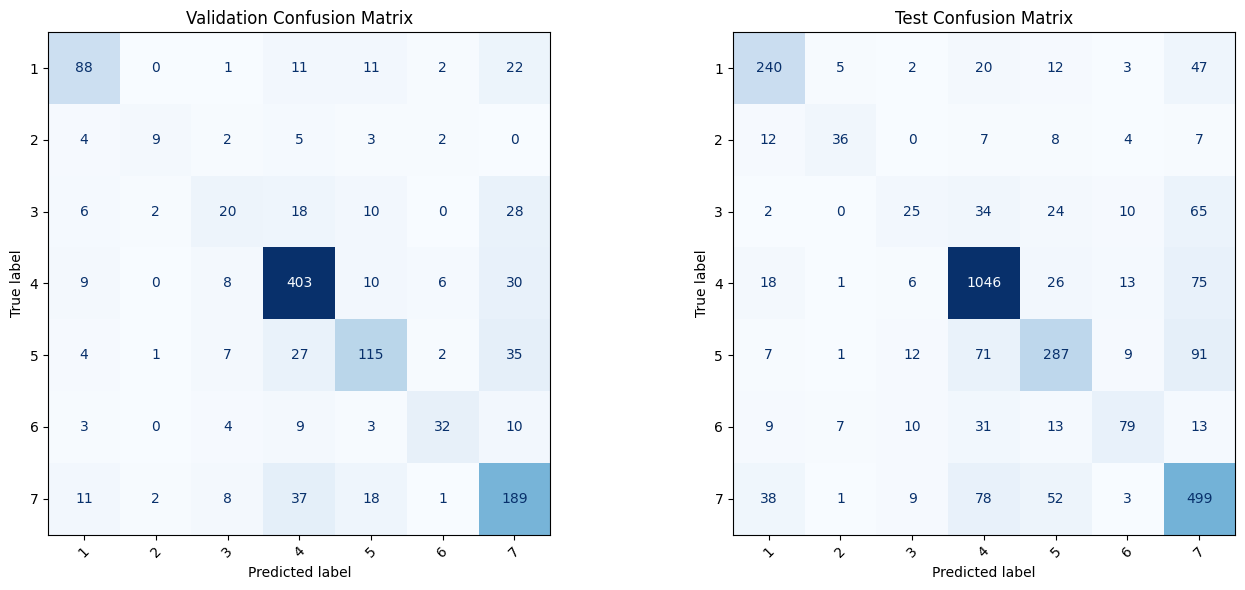

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# get class names from the dataset
class_names = test_loader.dataset.classes

# confusion matrices
cm_val = confusion_matrix(val_labels, val_preds)
cm_test = confusion_matrix(test_labels, test_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Validation cm
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)
disp_val.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[0].set_title("Validation Confusion Matrix")

# Test cm
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
disp_test.plot(ax=axes[1], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()